In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torchvision
import torch

import matplotlib.pyplot as plt

from pathlib import Path
import logging

import time

import pickle
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset

from mingpt.utils import set_seed, sample
from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig

import os

In [3]:
set_seed(42)  # make deterministic

In [4]:
model_file = './best_model.pt'
data_path = './data/brain.pkl'

In [5]:
GPT_S = dict(
    embd_pdrop=0.0,
    resid_pdrop=0.0,
    attn_pdrop=0.0,
    n_layer=24,
    n_head=8,
    n_embd=512,
)


def now_utc():  # unix time
    seconds = round(time.time())
    millis = seconds * 1000
    unix = int(millis)
    return unix


def load_pickle(f_path):
    with open(f_path, 'rb') as fp:
        return pickle.load(fp)


def get_model(mconf):
    return GPT(mconf)

In [6]:
MY_GPT = dict(
    n_layer=16,
    n_embd=256
)
MY_GPT = {**GPT_S, **MY_GPT}  # inherit all other params

    
mconf = GPTConfig(
    256,
    1023,
    **MY_GPT,
    bert=False,
    use_embd=True,
)

In [7]:
device = torch.device('cpu')
model = get_model(mconf)
model.load_state_dict(torch.load(model_file, map_location=device))

<All keys matched successfully>

In [8]:
def get_train_test_split(X, y, test_size, random_state=42, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state  # reproducible results
    )

    if verbose:
        logging.getLogger(__name__).info('train data: X ~ {}, y ~ {}'.format(X_train.shape, y_train.shape))
        logging.getLogger(__name__).info('test data: X ~ {}, y ~ {}'.format(X_test.shape, y_test.shape))


    return X_train, X_test, y_train, y_test


def get_data(file_path, max_imgs=2000):
    dataset = load_pickle(Path(file_path).expanduser())

    if len(dataset) == 2:  # (images, masks)
        X = dataset[0]  # list of images
        y = dataset[1]  # list of corresponding mask
    else:  # unsupervised list of images
        X = np.array(dataset, dtype='float32')[:max_imgs]
        y = np.zeros(len(X))

    pixel_size = X.shape[1]  # should be == X.shape[2] == 32
    X = np.array(np.ceil(X * 255), dtype='float32')  # convert pixels to [0, 255] range
    y = np.array(np.ceil(y * 255), dtype='float32')

    X_train, X_test, y_train, y_test = get_train_test_split(X, y, 0.3, verbose=True)

    tensor_X_train = torch.Tensor(X_train)  # tensors
    tensor_y_train = torch.Tensor(y_train)
    tensor_X_test = torch.Tensor(X_test)
    tensor_y_test = torch.Tensor(y_test)

    t_train_dataset = TensorDataset(tensor_X_train, tensor_y_train)
    t_test_dataset = TensorDataset(tensor_X_test, tensor_y_test)

    return t_train_dataset, t_test_dataset, X_train


class ImageDataset(Dataset):
    def __init__(self, pt_dataset, perm=None):
        self.pt_dataset = pt_dataset

        flattened_image_size = 32 * 32
        self.perm = torch.arange(flattened_image_size) if perm is None else perm

        self.vocab_size = 256  # possible values for pixels
        self.block_size = flattened_image_size - 1

    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        image_channels = 1  # grayscale

        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1, image_channels)  # flatten out all pixels
        x = x[self.perm].float()  # reshuffle pixels with any fixed permutation and -> float
        a = x[:, 0]
        return a[:-1], a[1:]  # always just predict the next one in the sequence
    
    
def sample_some(trainer, model, dataset, X_train, n_samples=40, out_path='./samples.png'):
    prob = model_first_token(dataset, X_train)

    start_pixel = np.random.choice(np.arange(dataset.vocab_size), size=(n_samples, 1), replace=True, p=prob.numpy())
    start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
    flattened_image_size = 32 * 32
    pixels = sample(model, start_pixel, flattened_image_size - 1, temperature=1.0, sample=True, top_k=40)

    # for visualization we have to invert the permutation used to produce the pixels
    iperm = torch.argsort(dataset.perm)

    pixel_size = 32

    n_cols = 8
    n_rows = n_samples // n_cols
    fig, axis = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    for i, ax in enumerate(axis.ravel()):
        pxi = pixels[i][iperm]  # undo the encoding permutation
        pxi = pxi.view(pixel_size, pixel_size).cpu().numpy().astype(np.uint8)  # grayscale -> 2D

        ax.imshow(pxi, cmap='magma')
        ax.axis('off')

    plt.savefig(out_path)
    
    
def train(model, n_epochs, train_dataset, test_dataset, checkpoint_path):
    tokens_per_epoch = len(train_dataset) * train_dataset.block_size

    # initialize a trainer instance and kick off training
    tconf = TrainerConfig(
        max_epochs=n_epochs,
        batch_size=4,
        learning_rate=3e-3,
        betas=(0.9, 0.95),
        weight_decay=0,
        lr_decay=True,
        warmup_tokens=tokens_per_epoch,
        final_tokens=n_epochs * tokens_per_epoch,
        ckpt_path=checkpoint_path,
        num_workers=1
    )
    trainer = Trainer(model, train_dataset, test_dataset, tconf)
    # already train trainer.train()

    return trainer


def model_first_token(dataset, X_train, n_clusters=256):
    counts = torch.ones(n_clusters)  # start counts as 1 not zero, this is called "smoothing"
    rp = torch.randperm(len(dataset))
    nest = X_train.shape[0] // 2  # how many images to use for the estimation

    for i in range(nest):
        a, _ = dataset[int(rp[i])]
        t = a[0].item()  # index of first token in the sequence
        counts[int(t)] += 1

    prob = counts / counts.sum()  # normalize to have sum (prob) = 1
    return prob

In [9]:
t_train_dataset, t_test_dataset, X_train = get_data(data_path)  # raw data
train_dataset = ImageDataset(t_train_dataset)  # build dataset
test_dataset = ImageDataset(t_test_dataset)

trainer = train(model, 50, train_dataset, test_dataset, './latest_model.pt')

In [15]:
b, t, d = token_embeddings.size()
print(b, t, d)

4 10 2


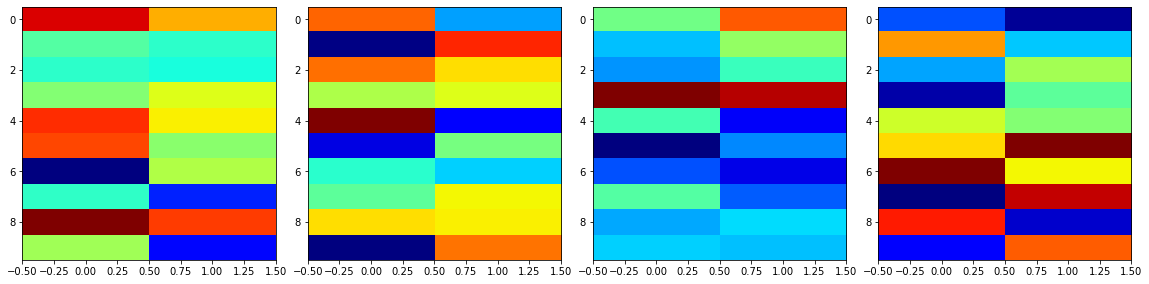

In [28]:
token_embeddings = torch.rand(4, 10, 2)
_b, _t, _d = token_embeddings.size()

n_cols = 4
n_rows = 1
fig, axis = plt.subplots(n_rows, n_cols, figsize=(16, 8))
for i, ax in enumerate(axis.ravel()):
    ti = token_embeddings[i]
    ti = ti.view(_t, _d).numpy()

    ax.imshow(ti, cmap='jet')
    # ax.axis('off')
    
    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, 10)
    ax.set_aspect(aspect=2.0/10.0)

    
plt.tight_layout()
# plt.savefig('wowee.png')